In [1]:
import glob
import os
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from scipy.special import psi
import numpy.linalg as la
from scipy.signal import argrelextrema
from scipy.linalg import expm
from scipy.special import digamma
from sklearn.neighbors import BallTree, KDTree

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from sklearn.metrics import mutual_info_score

# uint i to binary bin(i,q_bit): max(i)=15., q_bit=4
# 该转换规则为一种样例，可考虑其他转二值序列方法。得到的序列用于输入下面的HKS_calculation函数中生成KS熵矩阵
def int_to_binary(numbers):
    binlist = np.array([f'{int(num):04b}' for num in numbers])
    concatenated_string = ''.join(binlist)
    sequence = np.array(list(concatenated_string), dtype=int)
    return sequence

# uint i to binary bin(i), random spikes (1) of total number i in 15 time windows
# 另一种转换规则，即将int15映射到具有对应脉冲次数的15时间窗内
def int_to_binary_random(numbers):
    binary_arrays = [(np.arange(15) < val).astype(int) for val in numbers]
    for binary_array in binary_arrays:
        np.random.shuffle(binary_array)
    sequence = np.hstack(binary_arrays)
    return sequence

# smooth the spike array
# 对脉冲数组进行光滑处理
def smooth_sequence(arr):
    n = len(arr)
    smoothed_arr = arr.copy()
    
    start_indices = np.concatenate(([0], np.where(np.diff(arr) != 0)[0] + 1))
    end_indices = np.concatenate((start_indices[1:], [n]))
    
    for start, end in zip(start_indices, end_indices):
        if end - start > 2:
            x = np.arange(start, end)
            y = arr[start:end]
            try:
                f = interp1d(x, y, kind='cubic')
                smoothed_arr[start:end] = f(x)
            except ValueError:
                f = interp1d(x, y, kind='linear')
                smoothed_arr[start:end] = f(x)
        elif end - start == 2:
            x = np.arange(start, end)
            y = arr[start:end]
            f = interp1d(x, y, kind='linear')
            smoothed_arr[start:end] = f(x)
        else:
            smoothed_arr[start:end] = arr[start:end]
    
    smoothed_arr = np.array(smoothed_arr)
    
    return smoothed_arr

# Input: a spike train (0/1); Output: the KS Entropy matrix of the spike train
# 计算脉冲序列的KS熵值
def HKS_calculation(spike_train, smooth = False):
    # MLE of lambda in Poisson distribution equals to the sample average
    spike_numlist = np.cumsum(spike_train)
    lambda_mle_list = spike_numlist
    if smooth:
        lambda_mle_list = smooth_sequence(lambda_mle_list)

    t_max = len(spike_train)
    r_max = int(1.2 * np.max(lambda_mle_list))
    tau_max = int(t_max / 5)  # 默认计算时间长度t=0.8*t_max，前向时间长度tau=0.2*t_max，可手动调节
    time_windows = 0.2

    HKS_matrix = np.zeros((t_max - tau_max, tau_max))
    log_prob_from_initial = np.zeros((t_max - tau_max, r_max))
    
    # Precompute prob_from_initial
    for t in range(t_max - tau_max):
        if t == 0:
            log_prob_from_initial[t, 0] = 0
        else:
            log_prob_from_initial[t, 0] = -lambda_mle_list[t - 1]
            for r in range(1, r_max):
                log_prob_from_initial[t, r] = log_prob_from_initial[t, r - 1] + np.log(lambda_mle_list[t - 1]) - np.log(r)
    
    for t in range(t_max - tau_max):
        log_prob_from_t = np.zeros((tau_max, r_max))
        for tau in range(tau_max):
            if t == 0:
                lam = lambda_mle_list[t + tau]
            else:
                lam = lambda_mle_list[t + tau] - lambda_mle_list[t - 1]
            
            log_prob_from_t[tau, 0] = -lam
            for r in range(1, r_max):
                log_prob_from_t[tau, r] = log_prob_from_t[tau, r - 1] + np.log(lam) - np.log(r)
            
            for i in range(r_max):
                for j in range(i + 1, r_max):
                    if (-log_prob_from_t[tau, j - i]-log_prob_from_initial[t, i]) < 20:
                        log_term = 2*log_prob_from_initial[t, i] + log_prob_from_t[tau, j - i] + np.log(-log_prob_from_t[tau, j - i]-log_prob_from_initial[t, i])
                        HKS_matrix[t, tau] += np.exp(log_term)
            HKS_matrix[t, tau] = HKS_matrix[t, tau] / (tau + 1)

    return HKS_matrix

def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)

def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]

def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)

def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))

def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric="chebyshev")
    return KDTree(points, metric="chebyshev")

def lnc_correction(tree, points, k, alpha):
    e = 0
    n_sample = points.shape[0]
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point[None, :], k=k + 1, return_distance=False)[0]
        knn_points = points[knn]
        # Substract mean of k-nearest neighbor points
        knn_points = knn_points - knn_points[0]
        # Calculate covariance matrix of k-nearest neighbor points, obtain eigen vectors
        covr = knn_points.T @ knn_points / k
        _, v = la.eig(covr)
        # Calculate PCA-bounding box using eigen vectors
        V_rect = np.log(np.abs(knn_points @ v).max(axis=0)).sum()
        # Calculate the volume of original box
        log_knn_dist = np.log(np.abs(knn_points).max(axis=0)).sum()

        # Perform local non-uniformity checking and update correction term
        if V_rect < log_knn_dist + np.log(alpha):
            e += (log_knn_dist - V_rect) / n_sample
    return e

# 用于估计序列的Shannon Entropy
def entropy(x, k=3, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator
    x should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x = np.asarray(x)
    n_elements, n_features = x.shape
    x = add_noise(x)
    tree = build_tree(x)
    nn = query_neighbors(tree, x, k)
    const = digamma(n_elements) - digamma(k) + n_features * np.log(2)
    return (const + n_features * np.log(nn).mean()) / np.log(base)

# 基于knn的熵估计，可以手动调一下k的数值
def knn_entropy(data, k=3):
    """计算基于 k-nearest neighbor 的熵"""
    n = len(data)
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data.reshape(-1, 1))
    distances, _ = neigh.kneighbors(data.reshape(-1, 1))
    entropy = np.log(n) - np.mean(np.log(distances[:, k-1] + 1e-10))
    return entropy

# 用于估计两个序列之间的MI
def MutualInfoEstimation(x, y, z=None, k=3, base=np.e, alpha=0.001):
    """Mutual information of x and y (conditioned on z if z is not None)
    x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x)
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = (
            avgdigamma(x, dvec),
            avgdigamma(y, dvec),
            digamma(k),
            digamma(len(x)),
        )
        if alpha > 0:
            d += lnc_correction(tree, points, k, alpha)
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = (
            avgdigamma(xz, dvec),
            avgdigamma(yz, dvec),
            avgdigamma(z, dvec),
            digamma(k),
        )
    return (-a - b + c + d) / np.log(base)

# 按task_name, word_id, layer_name运行KS entropy计算，并保存至对应目录下
def process_layer(task_name, word_id, layer_name):
    paths = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name}.0.pth'))
    data = np.squeeze(np.array([torch.load(path) for path in paths]))

    for sentence_idx in range(data.shape[0]):
        sample_sequence = np.random.choice(np.arange(data.shape[2]), size=50, replace=False)
        for sample in sample_sequence:
            data_neuron = data[sentence_idx, :, sample]
            KS_Entropy = HKS_calculation(data_neuron)
            save_path = f"/nfs/xuhan/xyh/results/KS_entropy/{task_name}/{word_id}/{layer_name}.{sentence_idx}.{sample}.npy"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            np.save(save_path, KS_Entropy)
            print(f"For task {task_name}, word_id {word_id}, layer {layer_name}, sentence {sentence_idx}, neuron {sample}: KS Entropy calculated and saved.")


In [ ]:
layer_name_list = [
    'att.key.l0', 'att.key.l1', 'att.key.l2', 'att.key.l3', 'att.key.l4', 'att.key.l5',
    'att.key.l6', 'att.key.l7', 'att.key.l8', 'att.key.l9', 'att.key.l10', 'att.key.l11',
    'att.value.l0', 'att.value.l1', 'att.value.l2', 'att.value.l3', 'att.value.l4', 'att.value.l5',
    'att.value.l6', 'att.value.l7', 'att.value.l8', 'att.value.l9', 'att.value.l10', 'att.value.l11',
    'att.receptance.l0', 'att.receptance.l1', 'att.receptance.l2', 'att.receptance.l3', 'att.receptance.l4', 'att.receptance.l5',
    'att.receptance.l6', 'att.receptance.l7', 'att.receptance.l8', 'att.receptance.l9', 'att.receptance.l10', 'att.receptance.l11',
    'att.sigmoid.l0', 'att.sigmoid.l1', 'att.sigmoid.l2', 'att.sigmoid.l3', 'att.sigmoid.l4', 'att.sigmoid.l5',
    'att.sigmoid.l6', 'att.sigmoid.l7', 'att.sigmoid.l8', 'att.sigmoid.l9', 'att.sigmoid.l10', 'att.sigmoid.l11',
    
    'ffn.key.l0', 'ffn.key.l1', 'ffn.key.l2', 'ffn.key.l3', 'ffn.key.l4', 'ffn.key.l5',
    'ffn.key.l6', 'ffn.key.l7', 'ffn.key.l8', 'ffn.key.l9', 'ffn.key.l10', 'ffn.key.l11',
    'ffn.value.l0', 'ffn.value.l1', 'ffn.value.l2', 'ffn.value.l3', 'ffn.value.l4', 'ffn.value.l5',
    'ffn.value.l6', 'ffn.value.l7', 'ffn.value.l8', 'ffn.value.l9', 'ffn.value.l10', 'ffn.value.l11',
    'ffn.receptance.l0', 'ffn.receptance.l1', 'ffn.receptance.l2', 'ffn.receptance.l3', 'ffn.receptance.l4', 'ffn.receptance.l5',
    'ffn.receptance.l6', 'ffn.receptance.l7', 'ffn.receptance.l8', 'ffn.receptance.l9', 'ffn.receptance.l10', 'ffn.receptance.l11',
    'ffn.sigmoid.l0', 'ffn.sigmoid.l1', 'ffn.sigmoid.l2', 'ffn.sigmoid.l3', 'ffn.sigmoid.l4', 'ffn.sigmoid.l5',
    'ffn.sigmoid.l6', 'ffn.sigmoid.l7', 'ffn.sigmoid.l8', 'ffn.sigmoid.l9', 'ffn.sigmoid.l10', 'ffn.sigmoid.l11',
    
    'block.ln1.l0', 'block.ln1.l1', 'block.ln1.l2', 'block.ln1.l3', 'block.ln1.l4', 'block.ln1.l5',
    'block.ln1.l6', 'block.ln1.l7', 'block.ln1.l8', 'block.ln1.l9', 'block.ln1.l10', 'block.ln1.l11',
    'block.ln2.l0', 'block.ln2.l1', 'block.ln2.l2', 'block.ln2.l3', 'block.ln2.l4', 'block.ln2.l5',
    'block.ln2.l6', 'block.ln2.l7', 'block.ln2.l8', 'block.ln2.l9', 'block.ln2.l10', 'block.ln2.l11',
    
    'quant', 'block.ln0', 'head'
]

task_names = ['winogrande_true', 'winogrande_false', 'arc_easy_true', 'arc_easy_false']

word_ids_dict = {
    'winogrande_true': ['0', '1'],
    'winogrande_false': ['0', '1'],
    'arc_easy_true': ['0', '1', '2', '3'],
    'arc_easy_false': ['0', '1', '2', '3']
}

# 跑一个neuron的KS熵大概在10s，对于每一个layer可以多跑一些神经元
for task_name in task_names:
    word_ids = word_ids_dict[task_name]
    for word_id in word_ids:
        for layer_name in layer_name_list:
            process_layer(task_name, word_id, layer_name)


In [3]:
# 互信息计算demo (信息论分析)
# 这个例子说明了knn算法的问题，请不要正式运行这个代码块的文件来计算mi！

layer_name_list = [
    'att.key.l0','att.key.l1','att.key.l2','att.key.l3','att.key.l4','att.key.l5',
    'att.key.l6','att.key.l7','att.key.l8','att.key.l9','att.key.l10','att.key.l11',
    'att.value.l0','att.value.l1','att.value.l2','att.value.l3','att.value.l4','att.value.l5',
    'att.value.l6','att.value.l7','att.value.l8','att.value.l9','att.value.l10','att.value.l11',
    'att.receptance.l0','att.receptance.l1','att.receptance.l2','att.receptance.l3','att.receptance.l4','att.receptance.l5',
    'att.receptance.l6','att.receptance.l7','att.receptance.l8','att.receptance.l9','att.receptance.l10','att.receptance.l11',
    'att.sigmoid.l0','att.sigmoid.l1','att.sigmoid.l2','att.sigmoid.l3','att.sigmoid.l4','att.sigmoid.l5',
    'att.sigmoid.l6','att.sigmoid.l7','att.sigmoid.l8','att.sigmoid.l9','att.sigmoid.l10','att.sigmoid.l11',
    
    'ffn.key.l0','ffn.key.l1','ffn.key.l2','ffn.key.l3','ffn.key.l4','ffn.key.l5',
    'ffn.key.l6','ffn.key.l7','ffn.key.l8','ffn.key.l9','ffn.key.l10','ffn.key.l11',
    'ffn.value.l0','ffn.value.l1','ffn.value.l2','ffn.value.l3','ffn.value.l4','ffn.value.l5',
    'ffn.value.l6','ffn.value.l7','ffn.value.l8','ffn.value.l9','ffn.value.l10','ffn.value.l11',
    'ffn.receptance.l0','ffn.receptance.l1','ffn.receptance.l2','ffn.receptance.l3','ffn.receptance.l4','ffn.receptance.l5',
    'ffn.receptance.l6','ffn.receptance.l7','ffn.receptance.l8','ffn.receptance.l9','ffn.receptance.l10','ffn.receptance.l11',
    'ffn.sigmoid.l0','ffn.sigmoid.l1','ffn.sigmoid.l2','ffn.sigmoid.l3','ffn.sigmoid.l4','ffn.sigmoid.l5',
    'ffn.sigmoid.l6','ffn.sigmoid.l7','ffn.sigmoid.l8','ffn.sigmoid.l9','ffn.sigmoid.l10','ffn.sigmoid.l11',
    
    'block.ln1.l0','block.ln1.l1','block.ln1.l2','block.ln1.l3','block.ln1.l4','block.ln1.l5',
    'block.ln1.l6','block.ln1.l7','block.ln1.l8','block.ln1.l9','block.ln1.l10','block.ln1.l11',
    'block.ln2.l0','block.ln2.l1','block.ln2.l2','block.ln2.l3','block.ln2.l4','block.ln2.l5',
    'block.ln2.l6','block.ln2.l7','block.ln2.l8','block.ln2.l9','block.ln2.l10','block.ln2.l11',

    'quant','block.ln0','head'
]

task_name  ='arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name_1 = 'quant'
paths_1 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_1}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
# t = 句子*上下文数量*神经元
t_1 = np.squeeze(np.array([torch.load(path) for path in paths_1]))
t_1 = t_1.reshape(-1, t_1.shape[2])
# 脉冲数量序列转脉冲序列 (int to binary)
# layer_spike_1 = np.apply_along_axis(int_to_binary_random, 0, t_1)

layer_name_2 = 'att.receptance.l7'
paths_2 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_2}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
t_2 = np.squeeze(np.array([torch.load(path) for path in paths_2]))
t_2 = t_2.reshape(-1, t_2.shape[2])
# 脉冲数量序列转脉冲序列 (int to binary)
# layer_spike_2 = np.apply_along_axis(int_to_binary_random, 0, t_2)

mi_shape = (np.shape(t_1)[1], np.shape(t_2)[1])
mi_matrix = np.zeros(mi_shape)
mi_matrix_t = np.zeros(mi_shape)
joint_entropy_matrix = np.zeros(mi_shape)
entropy_1_list = np.zeros(mi_shape[0])
entropy_2_list = np.zeros(mi_shape[1])

for neuron_1 in range(mi_shape[0]):
    entropy_1_list[neuron_1] = knn_entropy(t_1[:,neuron_1].reshape(-1,1))
for neuron_2 in range(mi_shape[1]):
    entropy_2_list[neuron_2] = knn_entropy(t_2[:,neuron_2].reshape(-1,1))

for neuron_1 in range(mi_shape[0]):
    for neuron_2 in range(mi_shape[1]):
        mi = MutualInfoEstimation(t_1[:,neuron_1].reshape(-1,1), t_2[:,neuron_2].reshape(-1,1))
        mutual_info_score
        # mi = (mi>=0)*mi
        mi_matrix[neuron_1][neuron_2] = mi
    print('neuron: '+str(neuron_1+1)+'/'+str(mi_shape[0])+' done.')
    
for neuron_1 in range(mi_shape[0]):
    for neuron_2 in range(mi_shape[1]):
        joint = np.hstack((t_1[:,neuron_1].reshape(-1,1), t_2[:,neuron_2].reshape(-1,1)))
        joint_entropy_matrix[neuron_1][neuron_2] = knn_entropy(joint)
    print('neuron (joint): '+str(neuron_1+1)+'/'+str(mi_shape[0])+' done.')

print('entropy_1 average = '+str(np.mean(entropy_1_list)))
print('entropy_2 average = '+str(np.mean(entropy_2_list)))
print('entropy_joint average = '+str(np.mean(joint_entropy_matrix)))
print('MI average = '+str(np.mean(mi_matrix))) # 直接使用mi估计器计算得到的mi
print('MI (joint) average = '+str(np.mean(entropy_1_list)+np.mean(entropy_2_list)-np.mean(joint_entropy_matrix))) # 用knn进行信息熵估计，再通过边缘分布和联合分布概率熵的关系计算mi=entropy_1+entropy_2-entropy_joint


neuron: 1/768 done.
neuron: 2/768 done.
neuron: 3/768 done.
neuron: 4/768 done.
neuron: 5/768 done.
neuron: 6/768 done.
neuron: 7/768 done.
neuron: 8/768 done.
neuron: 9/768 done.
neuron: 10/768 done.
neuron: 11/768 done.
neuron: 12/768 done.
neuron: 13/768 done.
neuron: 14/768 done.
neuron: 15/768 done.
neuron: 16/768 done.
neuron: 17/768 done.
neuron: 18/768 done.
neuron: 19/768 done.
neuron: 20/768 done.
neuron: 21/768 done.
neuron: 22/768 done.
neuron: 23/768 done.
neuron: 24/768 done.
neuron: 25/768 done.
neuron: 26/768 done.
neuron: 27/768 done.
neuron: 28/768 done.
neuron: 29/768 done.
neuron: 30/768 done.
neuron: 31/768 done.
neuron: 32/768 done.
neuron: 33/768 done.
neuron: 34/768 done.
neuron: 35/768 done.
neuron: 36/768 done.
neuron: 37/768 done.
neuron: 38/768 done.
neuron: 39/768 done.
neuron: 40/768 done.
neuron: 41/768 done.
neuron: 42/768 done.
neuron: 43/768 done.
neuron: 44/768 done.
neuron: 45/768 done.
neuron: 46/768 done.
neuron: 47/768 done.
neuron: 48/768 done.
n

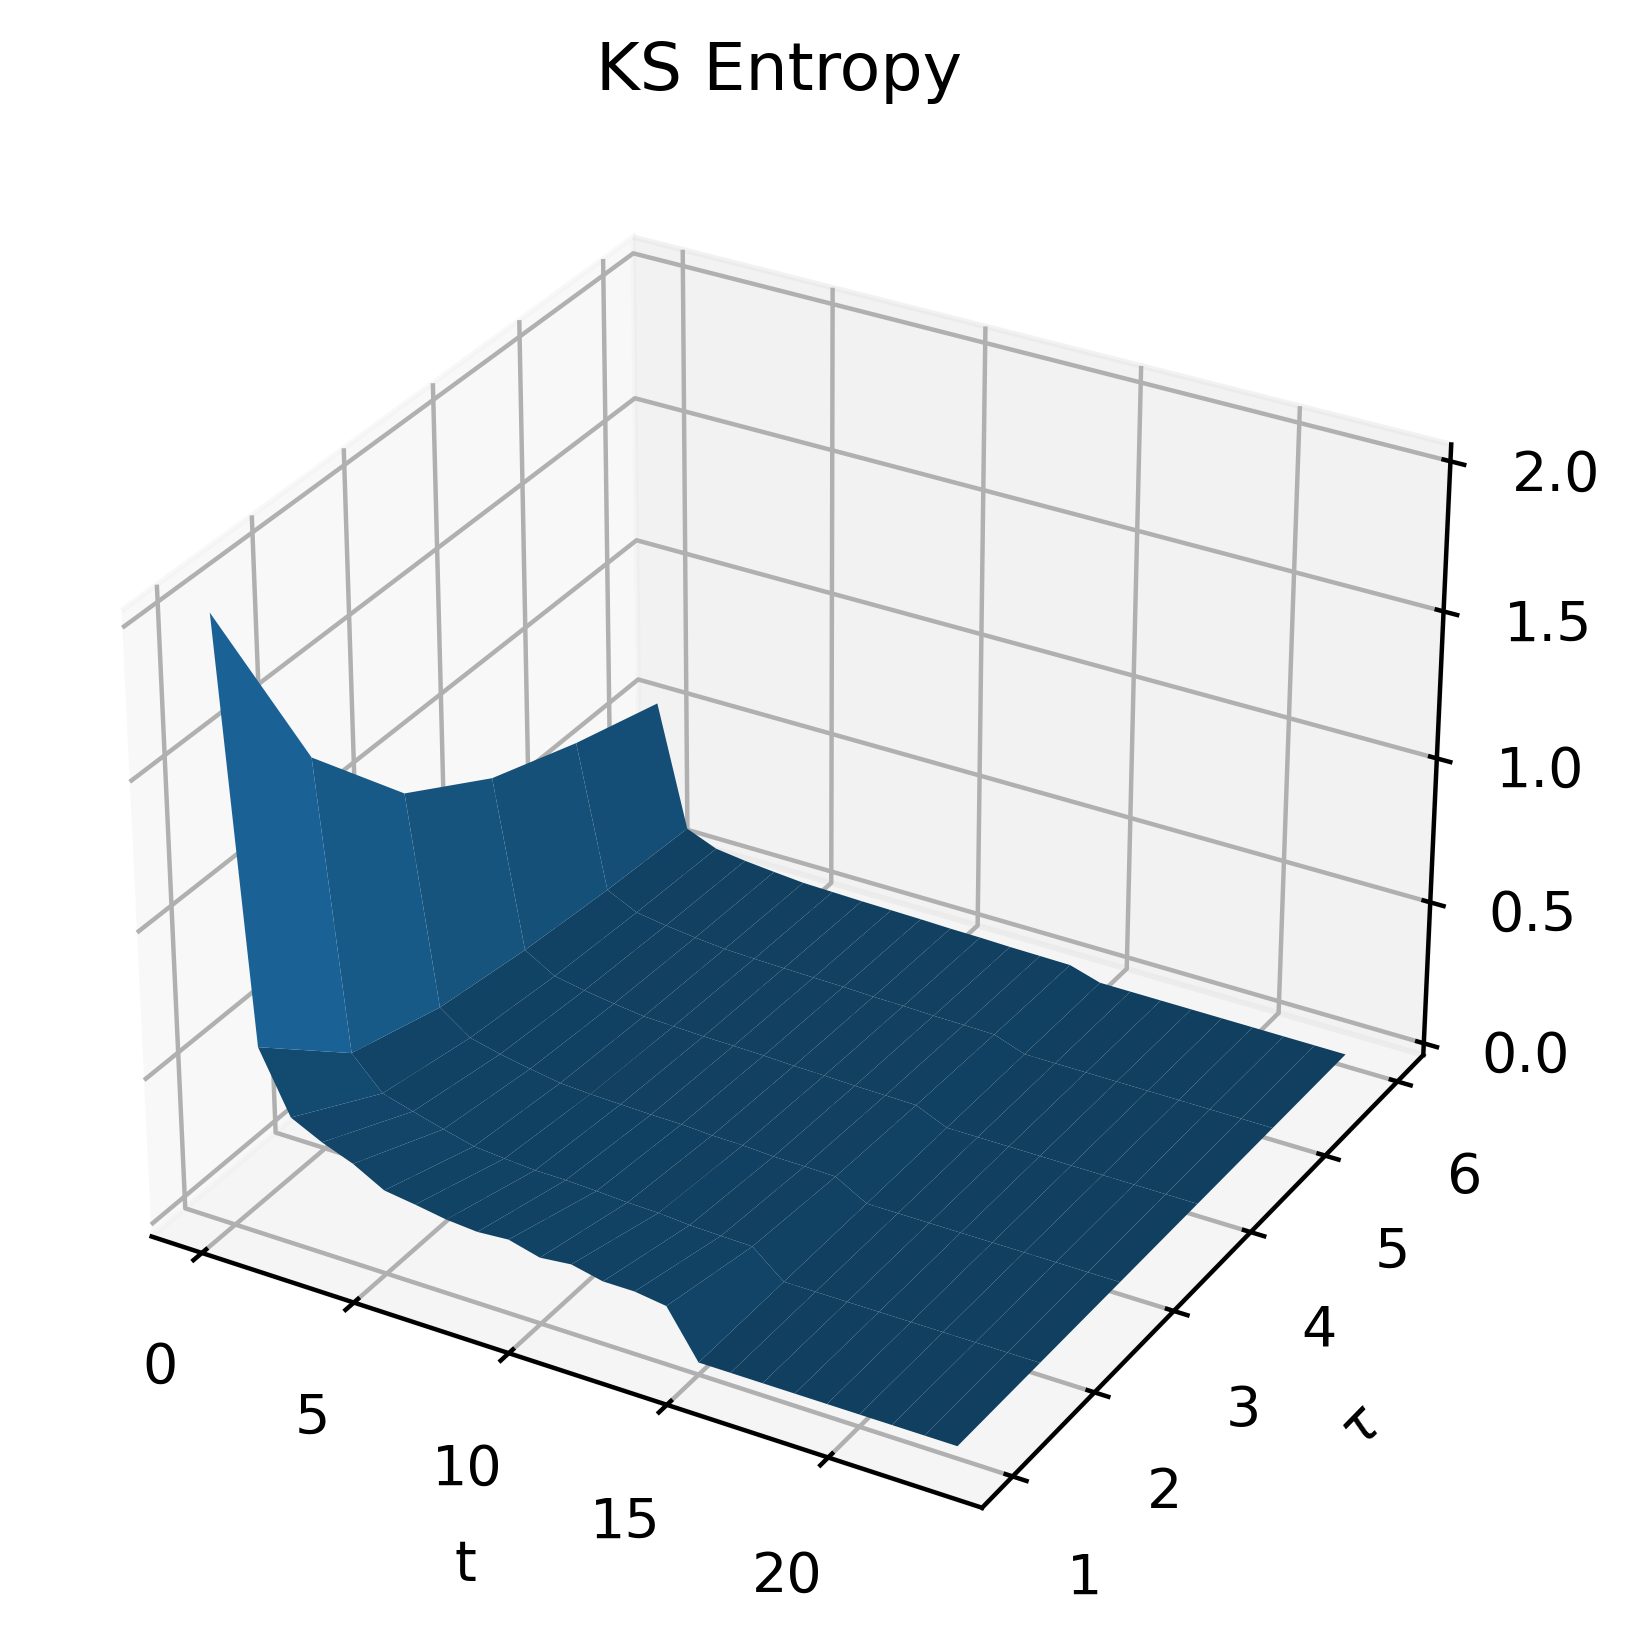

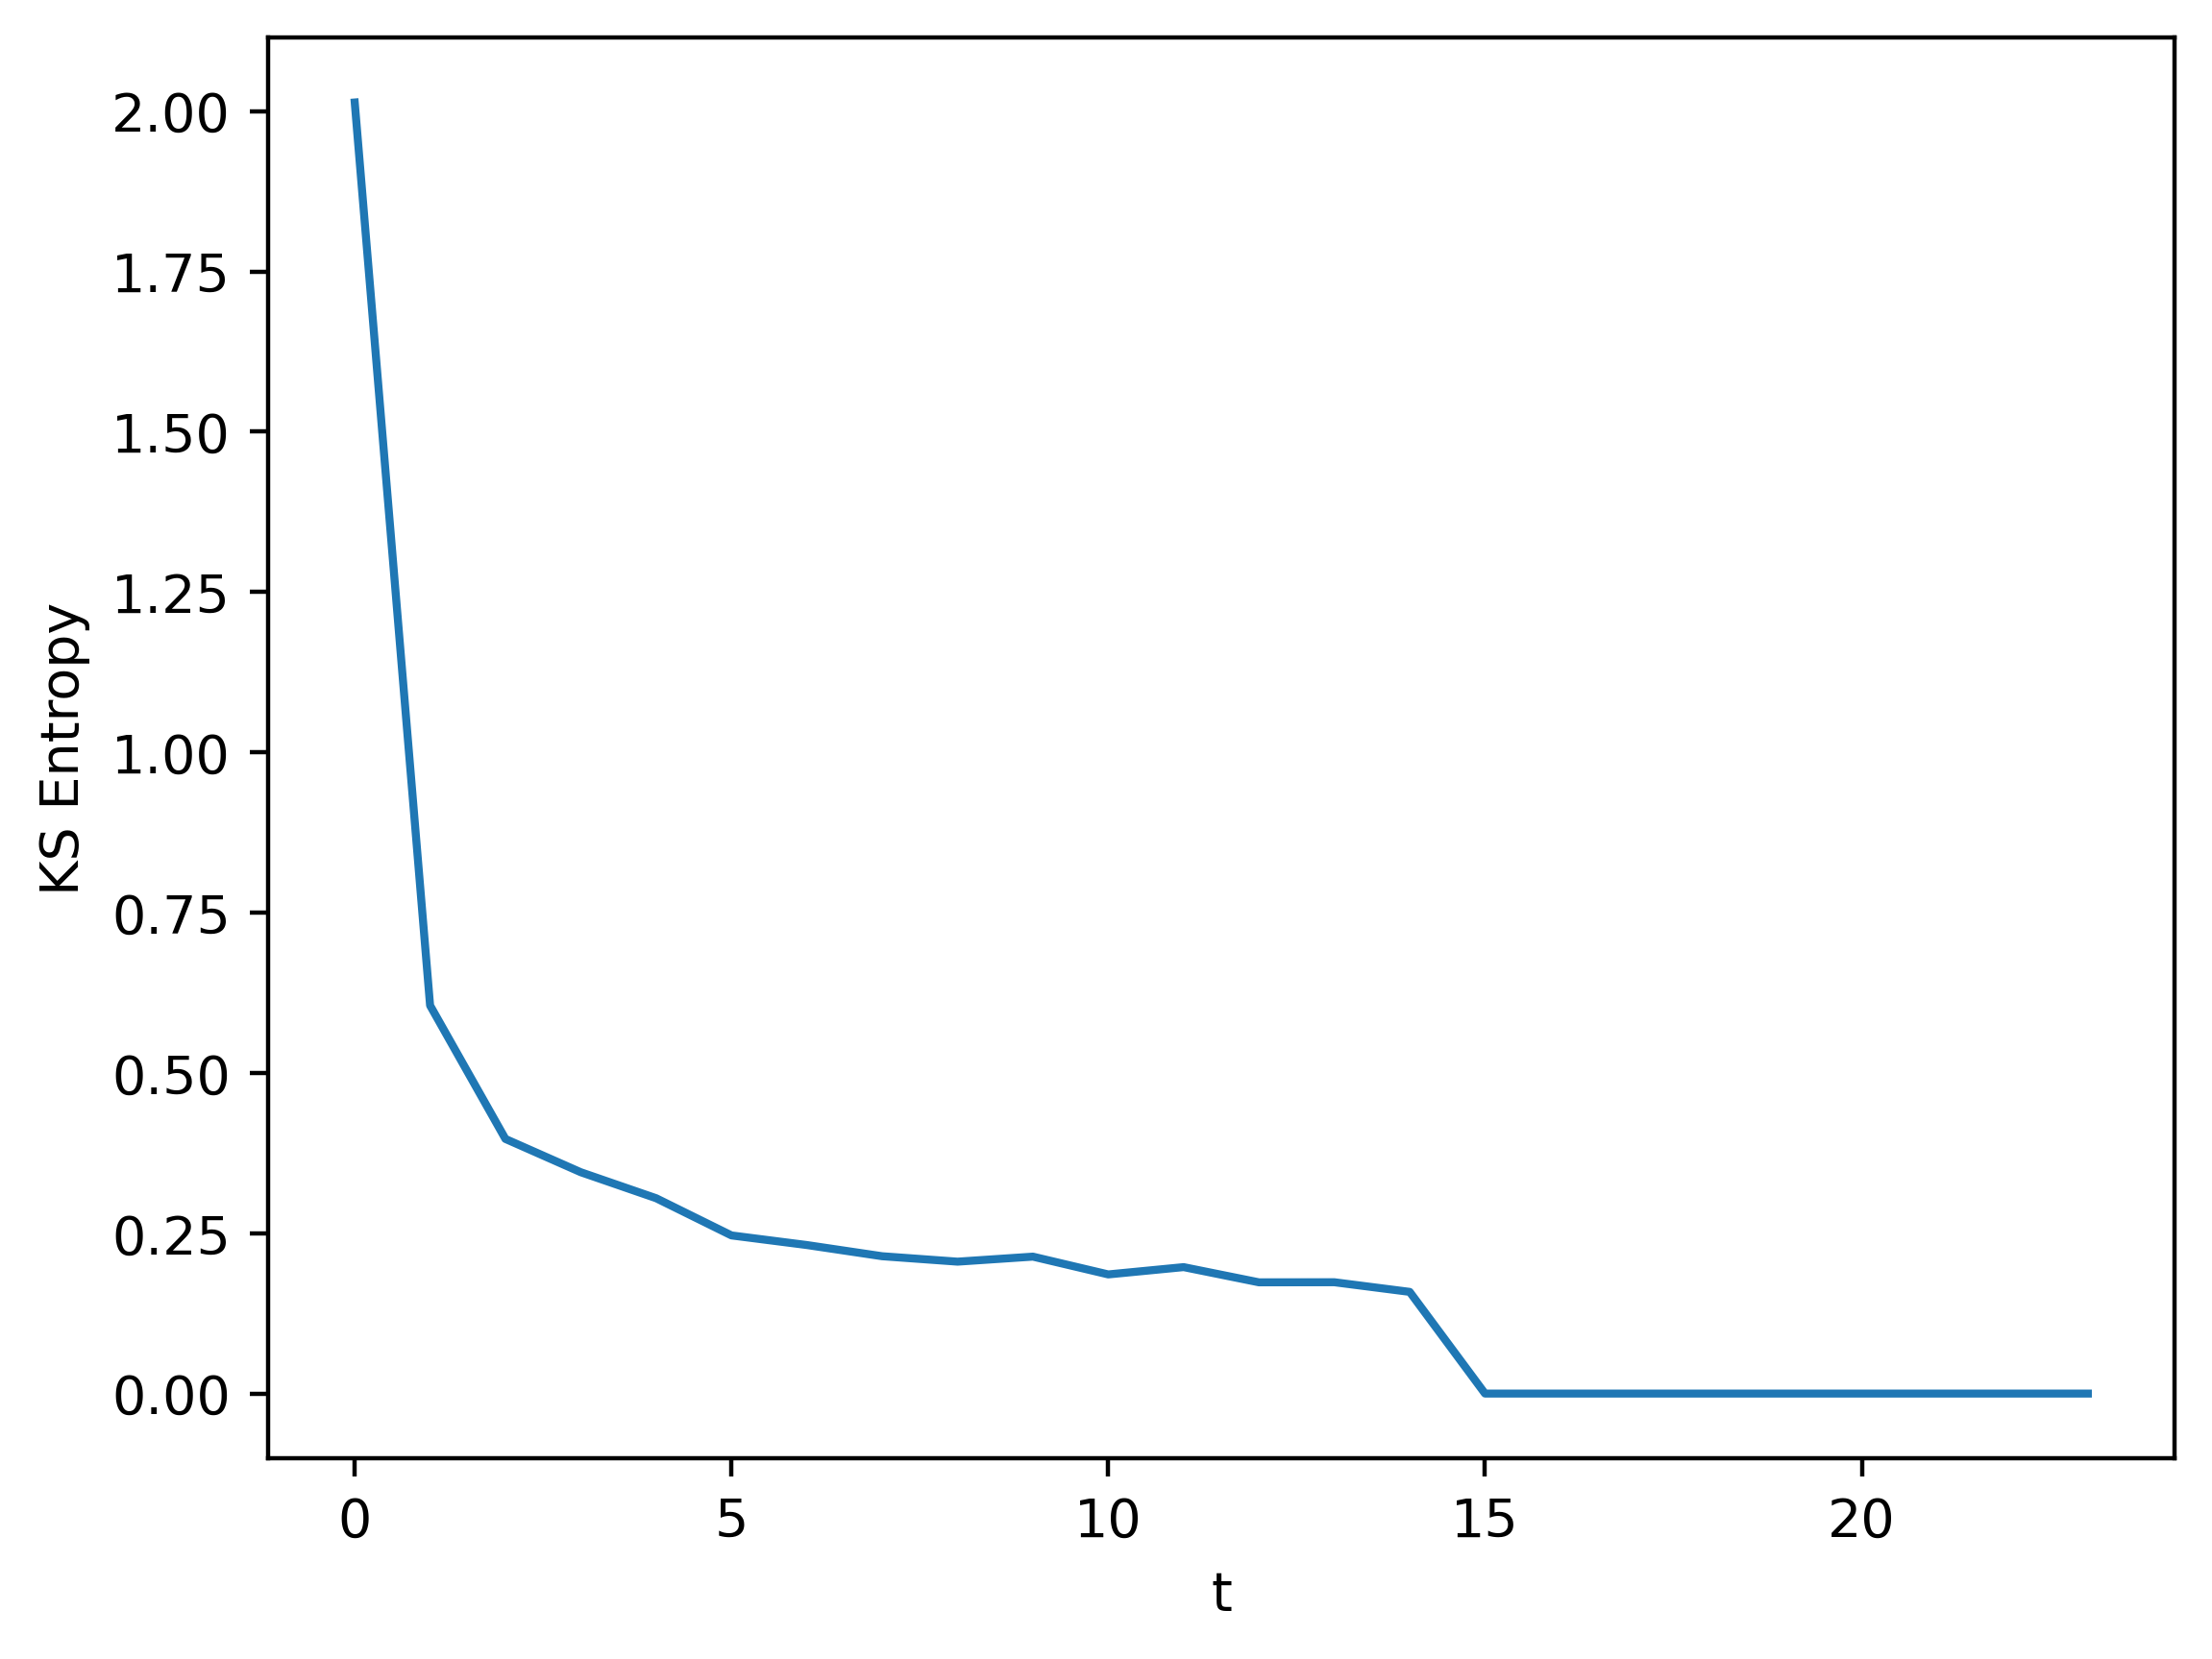

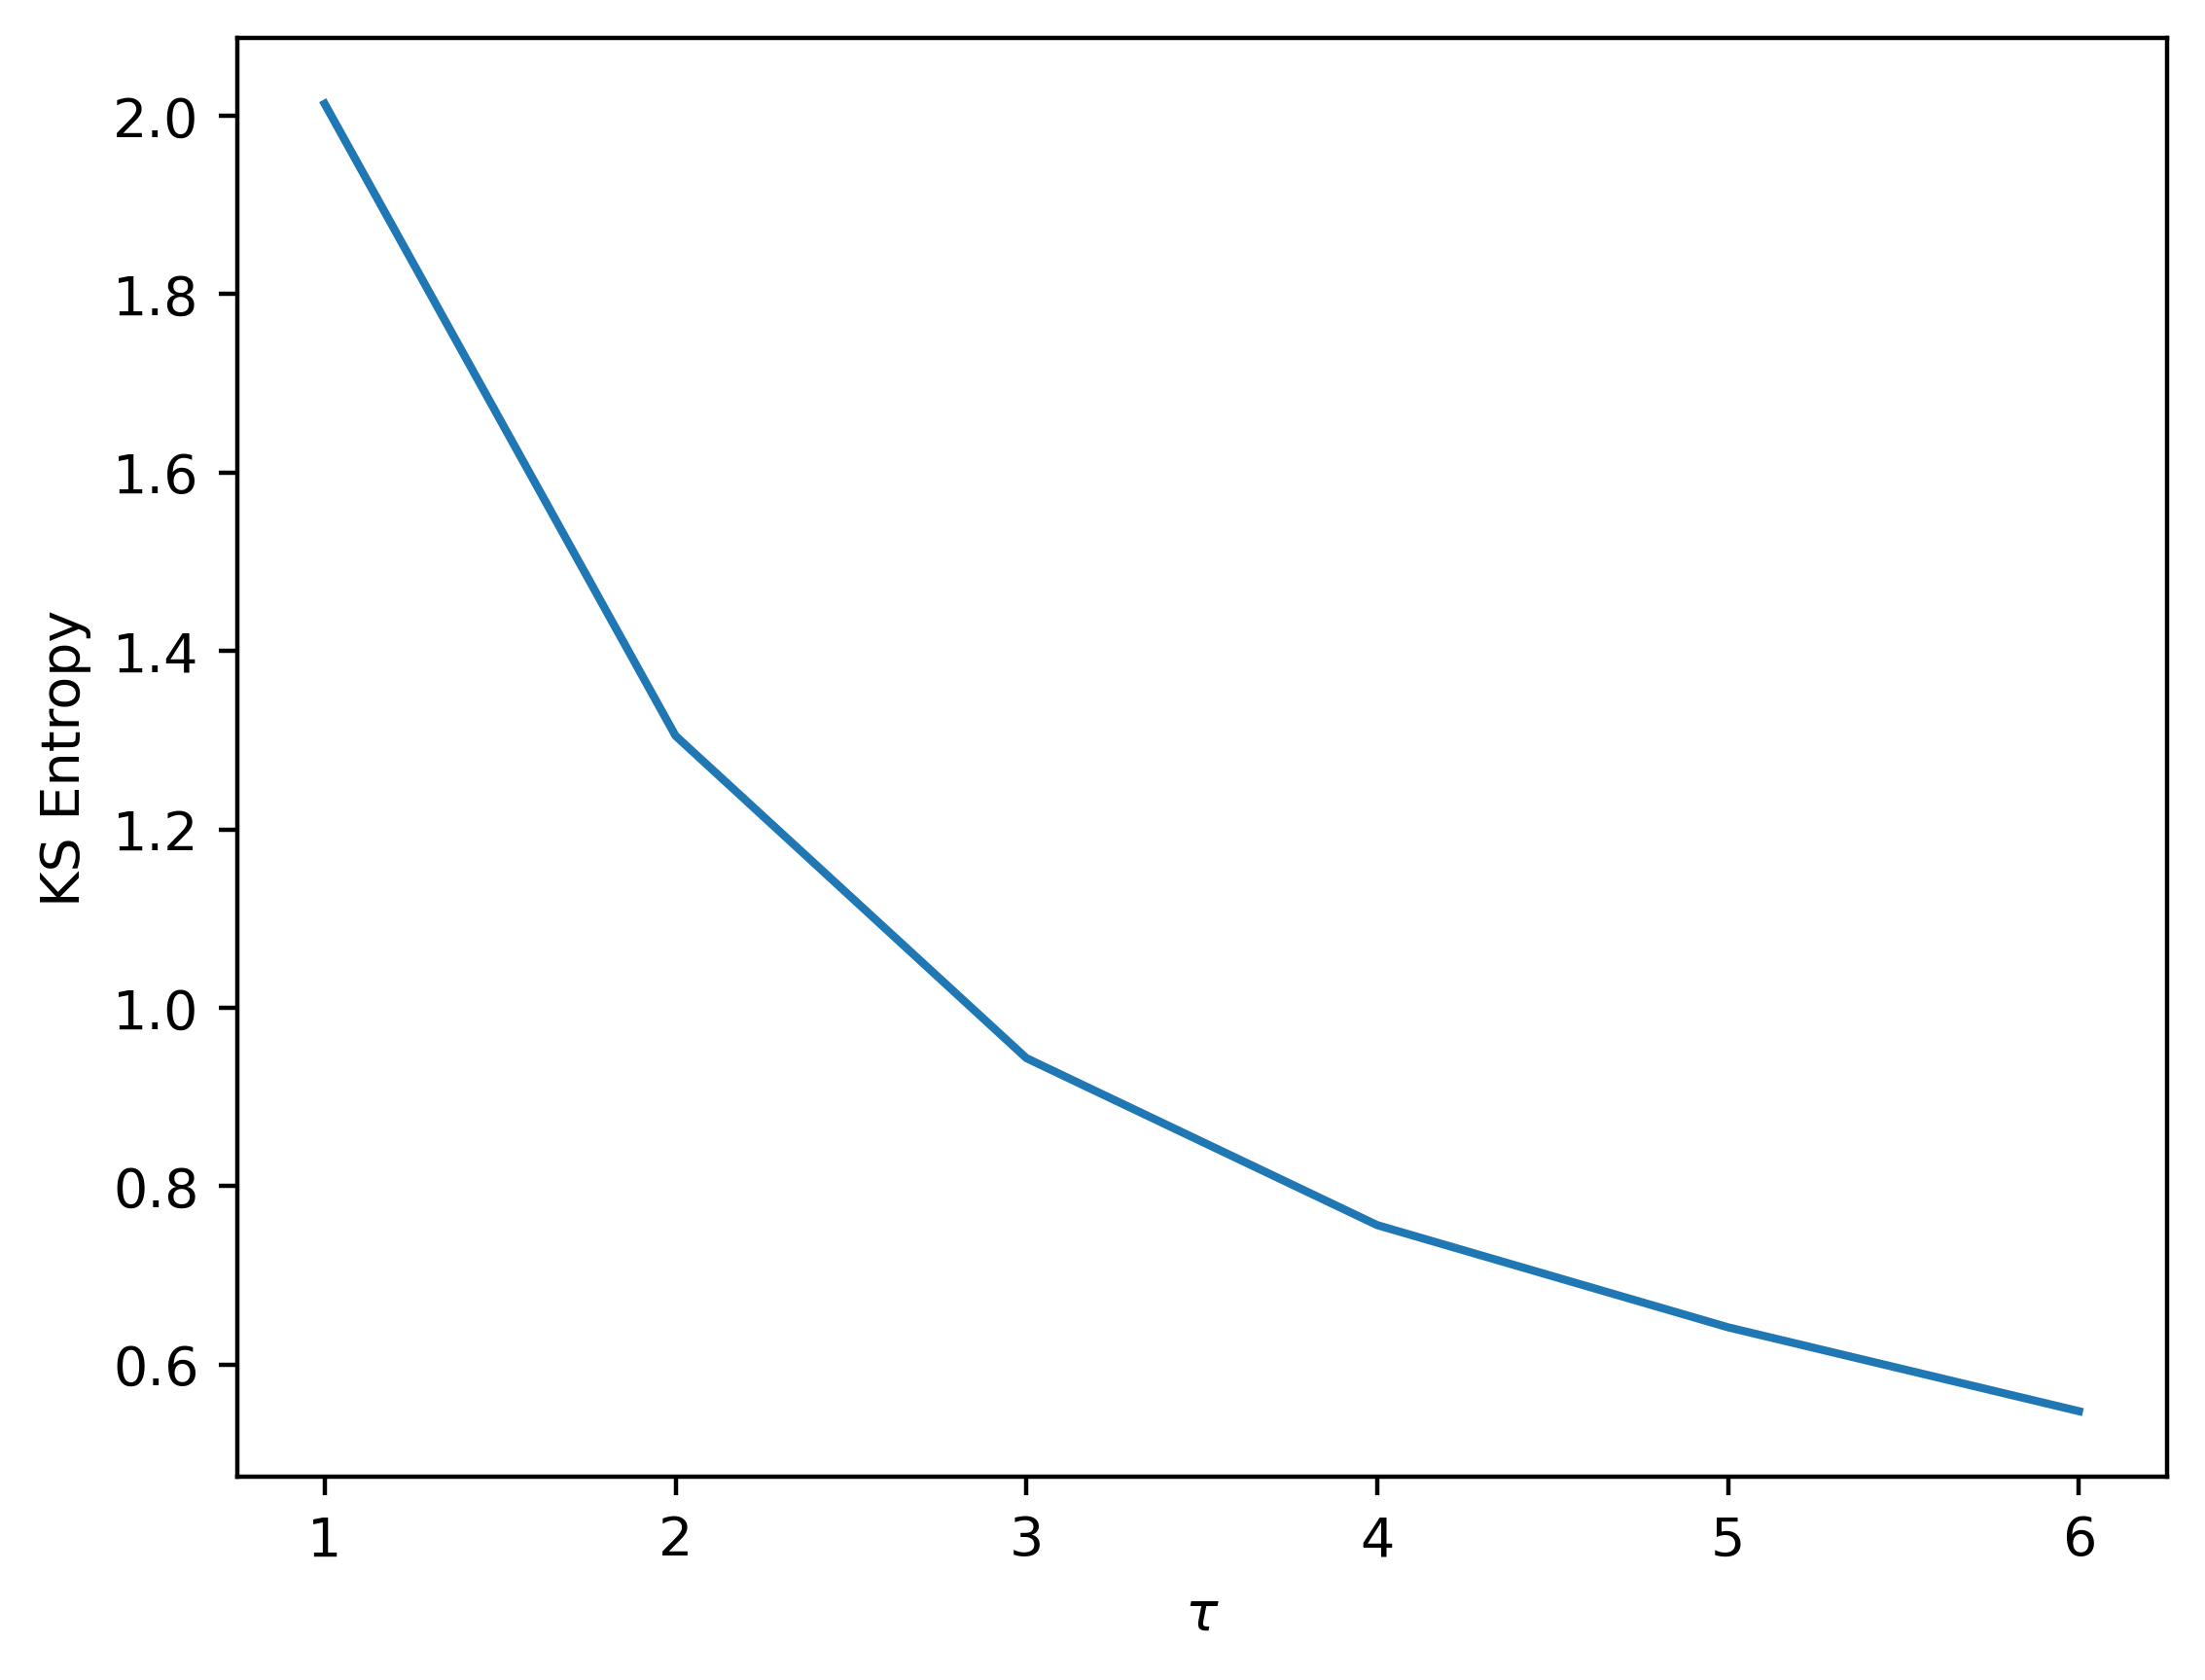

In [4]:
# KS熵计算demo (动力学分析)

import torch
import glob
import os
import numpy as np

# layer_name_list = [
#     'att.key.l0','att.key.l1','att.key.l2','att.key.l3','att.key.l4','att.key.l5',
#     'att.key.l6','att.key.l7','att.key.l8','att.key.l9','att.key.l10','att.key.l11',
#     'att.value.l0','att.value.l1','att.value.l2','att.value.l3','att.value.l4','att.value.l5',
#     'att.value.l6','att.value.l7','att.value.l8','att.value.l9','att.value.l10','att.value.l11',
#     'att.receptance.l0','att.receptance.l1','att.receptance.l2','att.receptance.l3','att.receptance.l4','att.receptance.l5',
#     'att.receptance.l6','att.receptance.l7','att.receptance.l8','att.receptance.l9','att.receptance.l10','att.receptance.l11',
#     'att.sigmoid.l0','att.sigmoid.l1','att.sigmoid.l2','att.sigmoid.l3','att.sigmoid.l4','att.sigmoid.l5',
#     'att.sigmoid.l6','att.sigmoid.l7','att.sigmoid.l8','att.sigmoid.l9','att.sigmoid.l10','att.sigmoid.l11',
    
#     'ffn.key.l0','ffn.key.l1','ffn.key.l2','ffn.key.l3','ffn.key.l4','ffn.key.l5',
#     'ffn.key.l6','ffn.key.l7','ffn.key.l8','ffn.key.l9','ffn.key.l10','ffn.key.l11',
#     'ffn.value.l0','ffn.value.l1','ffn.value.l2','ffn.value.l3','ffn.value.l4','ffn.value.l5',
#     'ffn.value.l6','ffn.value.l7','ffn.value.l8','ffn.value.l9','ffn.value.l10','ffn.value.l11',
#     'ffn.receptance.l0','ffn.receptance.l1','ffn.receptance.l2','ffn.receptance.l3','ffn.receptance.l4','ffn.receptance.l5',
#     'ffn.receptance.l6','ffn.receptance.l7','ffn.receptance.l8','ffn.receptance.l9','ffn.receptance.l10','ffn.receptance.l11',
#     'ffn.sigmoid.l0','ffn.sigmoid.l1','ffn.sigmoid.l2','ffn.sigmoid.l3','ffn.sigmoid.l4','ffn.sigmoid.l5',
#     'ffn.sigmoid.l6','ffn.sigmoid.l7','ffn.sigmoid.l8','ffn.sigmoid.l9','ffn.sigmoid.l10','ffn.sigmoid.l11',
    
#     'block.ln1.l0','block.ln1.l1','block.ln1.l2','block.ln1.l3','block.ln1.l4','block.ln1.l5',
#     'block.ln1.l6','block.ln1.l7','block.ln1.l8','block.ln1.l9','block.ln1.l10','block.ln1.l11',
#     'block.ln2.l0','block.ln2.l1','block.ln2.l2','block.ln2.l3','block.ln2.l4','block.ln2.l5',
#     'block.ln2.l6','block.ln2.l7','block.ln2.l8','block.ln2.l9','block.ln2.l10','block.ln2.l11',

#     'quant','block.ln0','head'
# ]

layer_name = 'ffn.value.l10'
#四个task的神经元id是一样的可以合并
task_name  ='arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'
paths = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name}.0.pth'))

# data = 句子*上下文长度*神经元
data = np.squeeze(np.array([torch.load(path) for path in paths]))
# print(data.shape)
# print(np.max(data))

# pick one neuron with the input of one chosen sentence (len = np.shape(data)[1])
data_selected = data[0,:,0]

# pick one neuron and flatten the array with sentence dimension (len = np.shape(data)[0]*np.shape(data)[1])
# data_neuron = data[:,:,0]
# data_selected = data_neuron.reshape((-1))

# uint to binary(8)
data_sequence = int_to_binary(data_selected)
data_sequence_random = int_to_binary_random(data_selected)

KS_matrix = HKS_calculation(data_selected)

t = np.arange(np.shape(KS_matrix)[0])
tau = np.arange(np.shape(KS_matrix)[1])+1

t, tau = np.meshgrid(t, tau, indexing='ij')
KS_entropy = KS_matrix

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111, projection='3d')
# cmap = plt.get_cmap('viridis')
# norm = plt.Normalize(KS_entropy.min(), KS_entropy.max())
# colors = cmap(norm(KS_entropy))
ax.plot_surface(t, tau, KS_entropy)

ax.set_title('KS Entropy')
ax.set_xlabel('t')
ax.set_ylabel('$\\tau$')
# ax.view_init(azim=-135)

plt.show()

t = np.arange(np.shape(KS_matrix)[0])
KS_entropy = KS_matrix
plt.figure(dpi=400)
plt.plot(t, KS_matrix[:, 0])
plt.xlabel('t')
plt.ylabel('KS Entropy')
plt.show()

tau = np.arange(np.shape(KS_matrix)[1])+1
KS_entropy = KS_matrix
plt.figure(dpi=400)
plt.plot(tau, KS_matrix[0, :])
plt.xlabel('$\\tau$')
plt.ylabel('KS Entropy')
plt.show()


In [2]:
# 互信息计算demo (信息论分析)

import torch
import glob
import os
import numpy as np

layer_name_list = [
    'att.key.l0','att.key.l1','att.key.l2','att.key.l3','att.key.l4','att.key.l5',
    'att.key.l6','att.key.l7','att.key.l8','att.key.l9','att.key.l10','att.key.l11',
    'att.value.l0','att.value.l1','att.value.l2','att.value.l3','att.value.l4','att.value.l5',
    'att.value.l6','att.value.l7','att.value.l8','att.value.l9','att.value.l10','att.value.l11',
    'att.receptance.l0','att.receptance.l1','att.receptance.l2','att.receptance.l3','att.receptance.l4','att.receptance.l5',
    'att.receptance.l6','att.receptance.l7','att.receptance.l8','att.receptance.l9','att.receptance.l10','att.receptance.l11',
    'att.sigmoid.l0','att.sigmoid.l1','att.sigmoid.l2','att.sigmoid.l3','att.sigmoid.l4','att.sigmoid.l5',
    'att.sigmoid.l6','att.sigmoid.l7','att.sigmoid.l8','att.sigmoid.l9','att.sigmoid.l10','att.sigmoid.l11',
    
    'ffn.key.l0','ffn.key.l1','ffn.key.l2','ffn.key.l3','ffn.key.l4','ffn.key.l5',
    'ffn.key.l6','ffn.key.l7','ffn.key.l8','ffn.key.l9','ffn.key.l10','ffn.key.l11',
    'ffn.value.l0','ffn.value.l1','ffn.value.l2','ffn.value.l3','ffn.value.l4','ffn.value.l5',
    'ffn.value.l6','ffn.value.l7','ffn.value.l8','ffn.value.l9','ffn.value.l10','ffn.value.l11',
    'ffn.receptance.l0','ffn.receptance.l1','ffn.receptance.l2','ffn.receptance.l3','ffn.receptance.l4','ffn.receptance.l5',
    'ffn.receptance.l6','ffn.receptance.l7','ffn.receptance.l8','ffn.receptance.l9','ffn.receptance.l10','ffn.receptance.l11',
    'ffn.sigmoid.l0','ffn.sigmoid.l1','ffn.sigmoid.l2','ffn.sigmoid.l3','ffn.sigmoid.l4','ffn.sigmoid.l5',
    'ffn.sigmoid.l6','ffn.sigmoid.l7','ffn.sigmoid.l8','ffn.sigmoid.l9','ffn.sigmoid.l10','ffn.sigmoid.l11',
    
    'block.ln1.l0','block.ln1.l1','block.ln1.l2','block.ln1.l3','block.ln1.l4','block.ln1.l5',
    'block.ln1.l6','block.ln1.l7','block.ln1.l8','block.ln1.l9','block.ln1.l10','block.ln1.l11',
    'block.ln2.l0','block.ln2.l1','block.ln2.l2','block.ln2.l3','block.ln2.l4','block.ln2.l5',
    'block.ln2.l6','block.ln2.l7','block.ln2.l8','block.ln2.l9','block.ln2.l10','block.ln2.l11',

    'quant','block.ln0','head'
]

task_name  ='arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name_1 = 'quant'
paths_1 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_1}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
# t = 句子*上下文数量*神经元
t_1 = np.squeeze(np.array([torch.load(path) for path in paths_1]))
t_1 = t_1.reshape(-1, t_1.shape[2])
# 脉冲数量序列转脉冲序列 (int to binary)
# layer_spike_1 = np.apply_along_axis(int_to_binary_random, 0, t_1)

layer_name_2 = 'ffn.receptance.l4'
paths_2 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_2}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
t_2 = np.squeeze(np.array([torch.load(path) for path in paths_2]))
t_2 = t_2.reshape(-1, t_2.shape[2])
# 脉冲数量序列转脉冲序列 (int to binary)
# layer_spike_2 = np.apply_along_axis(int_to_binary_random, 0, t_2)

# layer_joint = np.hstack((layer_spike_1, layer_spike_2))
# entropy_layer_1 = entropy(layer_spike_1)
# entropy_layer_2 = entropy(layer_spike_2)
# entropy_layer_joint = entropy(layer_joint)
# mi_layer = entropy_layer_1 + entropy_layer_2 - entropy_layer_joint
# mi_layer = (mi_layer>=0)*mi_layer
# print('entropy_layer_1='+str(entropy_layer_1))
# print('entropy_layer_2='+str(entropy_layer_2))
# print('mi(spike)='+str(mi_layer))

# joint = np.hstack((t_1, t_2))
# entropy_1 = entropy(t_1)
# entropy_2 = entropy(t_2)
# entropy_joint = entropy(joint)
# mi = entropy_1 + entropy_2 - entropy_joint
# mi = (mi>=0)*mi
# print('entropy_1='+str(entropy_1))
# print('entropy_2='+str(entropy_2))
# print('mi(original)='+str(mi))
# print('-------------------------------')

# for neuron_1 in layer_name_list:
#     paths_2 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_05_29/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_2}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
#     t_2 = np.array([torch.load(path) for path in paths_2])
#     layer_spike_2 = np.apply_along_axis(int_to_binary_random, 0, t_2)

#     layer_joint = np.hstack((layer_spike_1, layer_spike_2))
#     entropy_layer_1 = entropy(layer_spike_1)
#     entropy_layer_2 = entropy(layer_spike_2)
#     entropy_layer_joint = entropy(layer_joint)
#     mi_layer = entropy_layer_1 + entropy_layer_2 - entropy_layer_joint
#     # mi_layer = (mi_layer>=0)*mi_layer
#     # print('entropy_layer_1='+str(entropy_layer_1))
#     # print('entropy_layer_2='+str(entropy_layer_2))
#     print('mi(spike)='+str(mi_layer))

#     joint = np.hstack((t_1, t_2))
#     entropy_1 = entropy(t_1)
#     entropy_2 = entropy(t_2)
#     entropy_joint = entropy(joint)
#     mi = entropy_1 + entropy_2 - entropy_joint
#     # mi = (mi>=0)*mi
#     # print('entropy_1='+str(entropy_1))
#     # print('entropy_2='+str(entropy_2))
#     print('mi(original)='+str(mi))
#     print('-------------------------------')


In [4]:
# 互信息计算demo (信息论分析)

import torch
import glob
import os
import numpy as np

layer_name_list = [
    'att.key.l0','att.key.l1','att.key.l2','att.key.l3','att.key.l4','att.key.l5',
    'att.key.l6','att.key.l7','att.key.l8','att.key.l9','att.key.l10','att.key.l11',
    'att.value.l0','att.value.l1','att.value.l2','att.value.l3','att.value.l4','att.value.l5',
    'att.value.l6','att.value.l7','att.value.l8','att.value.l9','att.value.l10','att.value.l11',
    'att.receptance.l0','att.receptance.l1','att.receptance.l2','att.receptance.l3','att.receptance.l4','att.receptance.l5',
    'att.receptance.l6','att.receptance.l7','att.receptance.l8','att.receptance.l9','att.receptance.l10','att.receptance.l11',
    'att.sigmoid.l0','att.sigmoid.l1','att.sigmoid.l2','att.sigmoid.l3','att.sigmoid.l4','att.sigmoid.l5',
    'att.sigmoid.l6','att.sigmoid.l7','att.sigmoid.l8','att.sigmoid.l9','att.sigmoid.l10','att.sigmoid.l11',
    
    'ffn.key.l0','ffn.key.l1','ffn.key.l2','ffn.key.l3','ffn.key.l4','ffn.key.l5',
    'ffn.key.l6','ffn.key.l7','ffn.key.l8','ffn.key.l9','ffn.key.l10','ffn.key.l11',
    'ffn.value.l0','ffn.value.l1','ffn.value.l2','ffn.value.l3','ffn.value.l4','ffn.value.l5',
    'ffn.value.l6','ffn.value.l7','ffn.value.l8','ffn.value.l9','ffn.value.l10','ffn.value.l11',
    'ffn.receptance.l0','ffn.receptance.l1','ffn.receptance.l2','ffn.receptance.l3','ffn.receptance.l4','ffn.receptance.l5',
    'ffn.receptance.l6','ffn.receptance.l7','ffn.receptance.l8','ffn.receptance.l9','ffn.receptance.l10','ffn.receptance.l11',
    'ffn.sigmoid.l0','ffn.sigmoid.l1','ffn.sigmoid.l2','ffn.sigmoid.l3','ffn.sigmoid.l4','ffn.sigmoid.l5',
    'ffn.sigmoid.l6','ffn.sigmoid.l7','ffn.sigmoid.l8','ffn.sigmoid.l9','ffn.sigmoid.l10','ffn.sigmoid.l11',
    
    'block.ln1.l0','block.ln1.l1','block.ln1.l2','block.ln1.l3','block.ln1.l4','block.ln1.l5',
    'block.ln1.l6','block.ln1.l7','block.ln1.l8','block.ln1.l9','block.ln1.l10','block.ln1.l11',
    'block.ln2.l0','block.ln2.l1','block.ln2.l2','block.ln2.l3','block.ln2.l4','block.ln2.l5',
    'block.ln2.l6','block.ln2.l7','block.ln2.l8','block.ln2.l9','block.ln2.l10','block.ln2.l11',

    'quant','block.ln0','head'
]

task_name  ='arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name_1 = 'quant'
paths_1 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_1}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
# t = 句子*上下文数量*神经元
t_1 = np.squeeze(np.array([torch.load(path) for path in paths_1]))
t_1 = t_1.reshape(-1, t_1.shape[2])
# 脉冲数量序列转脉冲序列 (int to binary)
# layer_spike_1 = np.apply_along_axis(int_to_binary_random, 0, t_1)

layer_name_2 = 'ffn.receptance.l4'
paths_2 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_2}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
t_2 = np.squeeze(np.array([torch.load(path) for path in paths_2]))
t_2 = t_2.reshape(-1, t_2.shape[2])
# 脉冲数量序列转脉冲序列 (int to binary)
# layer_spike_2 = np.apply_along_axis(int_to_binary_random, 0, t_2)
mi_shape = (np.shape(t_1)[1],np.shape(t_2)[1])
mi_matrix = np.zeros(mi_shape)

for neuron_1 in range(mi_shape[0]):
    for neuron_2 in range(mi_shape[1]):
        # joint = np.hstack((t_1[:,neuron_1].reshape(-1,1), t_2[:,neuron_2].reshape(-1,1)))
        # entropy_1 = entropy(t_1[:,neuron_1].reshape(-1,1))
        # entropy_2 = entropy(t_2[:,neuron_2].reshape(-1,1))
        # entropy_joint = entropy(joint)
        # mi = entropy_1 + entropy_2 - entropy_joint
        mi = MutualInfoEstimation(t_1[:,neuron_1].reshape(-1,1), t_2[:,neuron_2].reshape(-1,1))
        # mi = (mi>=0)*mi
        mi_matrix[neuron_1][neuron_2] = mi
    if (neuron_1+1)%20 == 0:
        print('neuron: '+str(neuron_1+1)+'/'+str(mi_shape[0])+' done.')

# print('entropy_layer_1='+str(entropy_layer_1))
# print('entropy_layer_2='+str(entropy_layer_2))
# print('entropy_layer_joint='+str(entropy_layer_joint))
# print('mi(spike)='+str(np.mean(mi_layer)))
# print('-------------------------------')

# print('entropy_1='+str(entropy_1))
# print('entropy_2='+str(entropy_2))
# print('entropy_joint='+str(entropy_joint))
print('mi average = '+str(np.mean(mi_matrix)))


neuron: 20/768 done.
neuron: 40/768 done.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
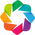

  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (300x1000 and 1x10)

In [3]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import holoviews as hv
import bokeh
hv.extension('bokeh')

task_name = 'arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name_1 = 'quant'
#四个task的神经元id是一样的可以合并
paths_1 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_05_29/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_1}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
# t = 句子*神经元
t_1 = np.array([torch.load(path) for path in paths_1])
layer_spike_1 = np.apply_along_axis(int_to_binary_random, 0, t_1)

layer_name_2 = 'ffn.receptance.l4'
paths_2 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_05_29/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_2}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
t_2 = np.array([torch.load(path) for path in paths_2])
layer_spike_2 = np.apply_along_axis(int_to_binary_random, 0, t_2)

H=10
n_epoch = 500

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    x_sample=np.apply_along_axis(int_to_binary_random, 0, t_1)
    y_sample=np.apply_along_axis(int_to_binary_random, 0, t_2)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

plot_x = np.arange(len(plot_loss))
plot_y = np.array(plot_loss).reshape(-1,)
hv.Curve((plot_x, -plot_y))


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
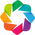

0.18796783398776057
0.07463724696741192


In [117]:
from npeet import entropy_estimators as ee
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import holoviews as hv
import bokeh
hv.extension('bokeh')

task_name = 'arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name_1 = 'quant'
#四个task的神经元id是一样的可以合并
paths_1 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_05_29/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_1}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
# t = 句子*神经元
t_1 = np.array([torch.load(path) for path in paths_1])
layer_spike_1 = np.apply_along_axis(int_to_binary, 0, t_1)

# layer_name_2 = 'ffn.receptance.l4'
layer_name_2 = 'att.value.l6'
paths_2 = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_05_29/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name_2}.0.pth')) # 这里我放在xyh文件夹下运行，因此使用完整路径
t_2 = np.array([torch.load(path) for path in paths_2])
layer_spike_2 = np.apply_along_axis(int_to_binary, 0, t_2)

print(ee.mi(layer_spike_1, layer_spike_2))
print(ee.mi(layer_spike_1, layer_spike_1))
